In [21]:
# %pip install torch
# %pip install wandb
# %pip install pandas
# %pip install numpy
# %pip install sklearn
# %pip install seaborn
# %pip install transformers
# %pip install matplotlib
# %pip install pytorch-lightning

In [1]:
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn
from tensorflow.test import gpu_device_name
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from transformers import AlbertForSequenceClassification, AlbertConfig, AlbertTokenizer

c:\Users\sgfri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available(),torch.cuda.device_count()

(False, 0)

In [3]:
device_name = gpu_device_name()
if device_name:
    print('Found GPU at: {}'.format(device_name))
else:
    print("No GPU found")

No GPU found


In [4]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")
print(train_df.describe())
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               16864  16864
unique                                              16330      2
top     FIFA takes on EA Sports video game in soccer’s...  Crime
freq                                                    4   8641
All entries unique: False
Null cells: 0


In [5]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
train_df.dropna()

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

All entries unique: True
Null cells: 0


In [6]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count', 'label_name'])

filtered_df['label_name'] = pd.Series(pd.Categorical(train_df['Label']))
filtered_df['label'] = (pd.Categorical(filtered_df['label_name']).codes).astype(int)
label_ids = dict(enumerate(filtered_df['label_name'].cat.categories))

print("Label IDs")
print(label_ids)

Label IDs
{0: 'Crime', 1: 'Non-Crime'}


In [11]:
train_df = train_df.head()
filtered_df = filtered_df.head()

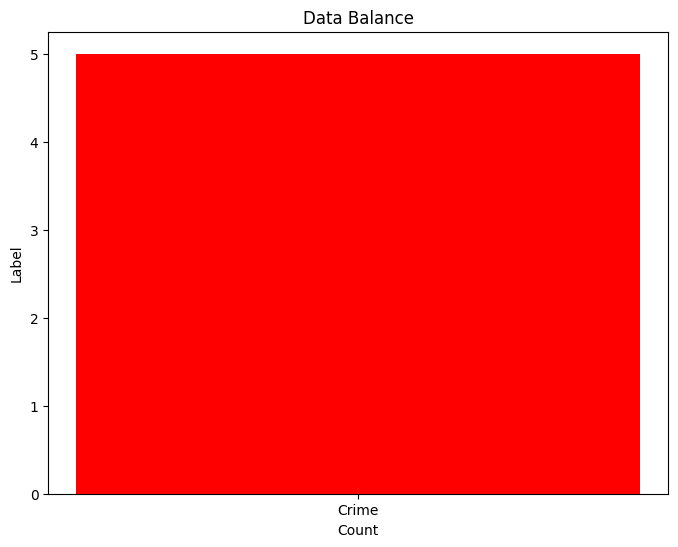

In [12]:
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

In [29]:
# oh_encoder = OneHotEncoder()
# enc_data=pd.DataFrame(oh_encoder.fit_transform(filtered_df[['label']]).toarray())
# print(enc_data.head())

In [13]:
def preprocess_x(data, get_word_count = False, single_entry=False):
    text_list = []
    word_count = []

    if not single_entry:
        for entry in data:
            new_text = re.sub("[^a-zA-Z]", " ", entry)
            word_count.append(len(new_text.split()))
            text_list.append(new_text)
    else:
        new_text = re.sub("[^a-zA-Z ]", " ", data)
        word_count.append(len(new_text.split()))
        text_list.append(new_text)
    
    if get_word_count:
        return text_list, word_count
    else:
        return text_list

In [14]:
filtered_df['text'], filtered_df['word_count'] = preprocess_x(train_df['Title'], get_word_count=True)

print(filtered_df.head())

                                                text  label  word_count  \
0  Minor raped by cop in Jharkhand s Hazaribagh  ...      0          10   
1   Saw my brother getting killed   Bhilwara vict...      0          14   
2  Delhi Police arrests burglar  recovers huge qu...      0          12   
3  Pregnant woman raped by hospital staff in UP s...      0          12   
4  Muzaffarpur     year old girl thrashed  gang r...      0           9   

  label_name  
0      Crime  
1      Crime  
2      Crime  
3      Crime  
4      Crime  


Word Count Stats:
count     5.000000
mean     11.400000
std       1.949359
min       9.000000
25%      10.000000
50%      12.000000
75%      12.000000
max      14.000000
Name: word_count, dtype: float64


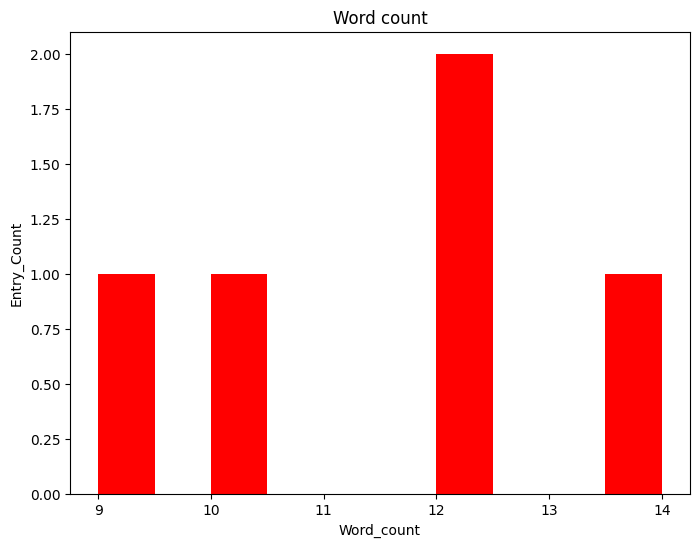

In [15]:
plt.figure(figsize=(8, 6))
print('Word Count Stats:')
print(filtered_df["word_count"].describe())
plt.hist(filtered_df['word_count'],color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [16]:
# tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=False)
# encodings = tokenizer.batch_encode_plus(text_list)

# print('tokenizer outputs: ', encodings.keys())

# input_ids = encodings['input_ids']
# token_type_ids = encodings['token_type_ids']
# attention_mask = encodings['attention_mask']

# input_id_train_val,input_id_test,token_type_id_train_val,token_type_id_test,attention_mask_train_val,\
#     attention_mask_test,y_train_val,y_test = train_test_split(input_ids, token_type_ids, attention_mask,\
#         filtered_df['label'], test_size=0.1,shuffle=True)

# input_id_train,input_id_val,token_type_id_train,token_type_id_val,attention_mask_train,attention_mask_val,\
#     y_train,y_val = train_test_split(input_id_train_val, token_type_id_train_val, attention_mask_train_val,\
#         y_train_val, test_size=0.2,shuffle=True)

ImportError: 
AlbertTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [47]:
class QTagDataset(Dataset):
  def __init__(self,quest,tags, tokenizer, max_len, num_workers = 8):
    self.tokenizer = tokenizer
    self.text = quest
    self.labels = tags
    self.max_len = max_len
      
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item_idx):
    text = self.text[item_idx]
    inputs = self.tokenizer.encode_plus(
      text,
      None,
      add_special_tokens=True,
      max_length= self.max_len,
      padding = 'max_length',
      return_token_type_ids= False,
      return_attention_mask= True,
      truncation=True,
      return_tensors = 'pt'
      )

    input_ids = inputs['input_ids'].flatten()
    attn_mask = inputs['attention_mask'].flatten()
              
    return {
      'input_ids': input_ids ,
      'attention_mask': attn_mask,
      'label':torch.tensor(self.labels[item_idx],dtype= torch.float)
    }

class QTagDataModule (pl.LightningDataModule):
  def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
    super().__init__()
    self.tr_text = x_tr
    self.tr_label = y_tr
    self.val_text = x_val
    self.val_label = y_val
    self.test_text = x_test
    self.test_label = y_test
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self, stage='None'):
    self.train_dataset = QTagDataset(quest=self.tr_text,  tags=self.tr_label,tokenizer=self.tokenizer,max_len= self.max_token_len)
    self.val_dataset= QTagDataset(quest=self.val_text, tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
    self.test_dataset =QTagDataset(quest=self.test_text, tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size= self.batch_size, shuffle = True , num_workers=4)

  def val_dataloader(self):
    return DataLoader (self.val_dataset,batch_size= self.batch_size, num_workers=4)

  def test_dataloader(self):
    return DataLoader (self.test_dataset,batch_size= self.batch_size, shuffle = True , num_workers=4)

class QTagClassifier(pl.LightningModule):
  def __init__(self,model_config,n_classes=10,steps_per_epoch=None,n_epochs=3, lr=2e-5):
    super().__init__()
    self.config = model_config

    self.bert=AlbertForSequenceClassification.from_pretrained(
      'albert-base-v2',
      ignore_mismatched_sizes=True,
      config = AlbertConfig()
    )
      # return_dict=True, 
      # num_labels=2)
    self.classifier=nn.Linear(self.bert.config.hidden_size,n_classes) 
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = n_epochs
    self.lr = lr
    self.criterion = nn.BCEWithLogitsLoss()
  def forward(self,input_ids, attn_mask):
    output = self.bert(input_ids=input_ids,attention_mask=attn_mask)
    output = self.classifier(output.pooler_output)
    return output
  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.forward(x)
    loss = F.cross_entropy(y_hat, y)
    return loss
  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.forward(x)
    loss = F.cross_entropy(y_hat, y)
    return loss
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=0.001)

In [41]:
x_train_val,x_test,y_train_val,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=0.1,shuffle=True)

x_train,x_val,y_train,y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, shuffle=True)

In [42]:
QTdata_module = QTagDataModule(x_train, y_train, x_val, y_val, x_test, y_test, tokenizer)

In [43]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
    verbose=True
)

In [48]:
model_config = AlbertConfig(hidden_size=768,num_attention_heads=12,intermediate_size=3072)
model=QTagClassifier(model_config=model_config)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

In [49]:
N_EPOCHS = 12
BATCH_SIZE = 32
MAX_LEN = 300
LR = 2e-05

wandb_logger = WandbLogger()
trainer = pl.Trainer(max_epochs = N_EPOCHS, callbacks=[checkpoint_callback], logger=wandb_logger)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [50]:
trainer.fit(model, QTdata_module)


  | Name       | Type                            | Params
---------------------------------------------------------------
0 | bert       | AlbertForSequenceClassification | 222 M 
1 | classifier | Linear                          | 41.0 K
2 | criterion  | BCEWithLogitsLoss               | 0     
---------------------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
890.579   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

In [ ]:
trainer.test(model,datamodule=QTdata_module)